In [13]:

import yaml
import sagemaker
import boto3
import pandas as pd
import os
import json
from time import gmtime, strftime
from sagemaker.sklearn.model import SKLearnModel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import yaml
import sagemaker

SETTING_FILE_PATH = "../config/settings.yaml"

# AWSリソース設定読み込み
with open(SETTING_FILE_PATH) as file:
    aws_info = yaml.safe_load(file)

sess = sagemaker.Session()

role = aws_info["aws"]["sagemaker"]["role"]
bucket = aws_info["aws"]["sagemaker"]["s3bucket"]
region = aws_info["aws"]["sagemaker"]["region"]


In [28]:
! echo "this is dummy model" > dummy_model.txt |tar -czf dummy_model.tar.gz dummy_model.txt

In [34]:
prefix = "latency_check"
model_file = "dummy_model.tar.gz"

s3_resource_session = boto3.Session().resource("s3").Bucket(bucket)
s3_resource_session.Object(os.path.join(prefix, "model", model_file)).upload_file(
    model_file
)


In [35]:
model_data = f"s3://{bucket}/{prefix}/model/{model_file}"
model = SKLearnModel(
    model_data=model_data,
    role=role,
    framework_version="0.23-1",
    py_version="py3",
    source_dir="model",
    entry_point="inference.py",
    sagemaker_session=sess,
)


In [36]:
timestamp = strftime("%Y%m%d-%H-%M-%S", gmtime())
model_name = "{}-{}".format("latency-check-model", timestamp)
endpoint_name = "{}-{}".format("latency-check-endpoint", timestamp)


sess.create_model(
    model_name, role, model.prepare_container_def(instance_type="ml.t2.medium")
)
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    endpoint_name=endpoint_name,
)


'latency-check-model-20221208-13-44-44'

-----------!

In [42]:
runtime = boto3.Session().client("sagemaker-runtime")
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept="application/json",
    Body="0",
)
# レスポンス確認
predictions = json.loads(response["Body"].read().decode("utf-8"))
print(predictions)


0


In [43]:
endpoint_name

'latency-check-endpoint-20221208-13-44-44'

In [2]:
!locust -f locust/locust_script.py -u 1 --headless --host='http://latency-check-endpoint-20221208-13-44-44' --stop-timeout 60 -L DEBUG -t 3m --logfile=logfile.log --csv=locust.csv --csv-full-history --reset-stats

latency-check-endpoint-20221208-13-44-44
 Name                                                          # reqs      # fails  |     Avg     Min     Max  Median  |   req/s failures/s
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------
 Aggregated                                                         0     0(0.00%)  |       0       0       0       0  |    0.00    0.00

 Name                                                          # reqs      # fails  |     Avg     Min     Max  Median  |   req/s failures/s
--------------------------------------------------------------------------------------------------------------------------------------------
 custom_protocol_boto3 sagemaker_client_invoke_endpoint            67     0(0.00%)  |      25      15     131      21 

## EC2からのlocust実行結果

In [5]:
df_stats = pd.read_csv("./locust.csv_stats.csv")


In [10]:

df_stats.iloc[:, 2:]

,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,Failures/s,50%,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,18144,0,9,9.225474,8,631,1.0,101.155604,0.0,9,9,9,9,10,10,11,14,20,600,630
1,18144,0,9,9.225474,8,631,1.0,101.155604,0.0,9,9,9,9,10,10,11,14,20,600,630


In [14]:
df_stats.columns

Index(['Type', 'Name', 'Request Count', 'Failure Count',
       'Median Response Time', 'Average Response Time', 'Min Response Time',
       'Max Response Time', 'Average Content Size', 'Requests/s', 'Failures/s',
       '50%', '66%', '75%', '80%', '90%', '95%', '98%', '99%', '99.9%',
       '99.99%', '100%'],
      dtype='object')

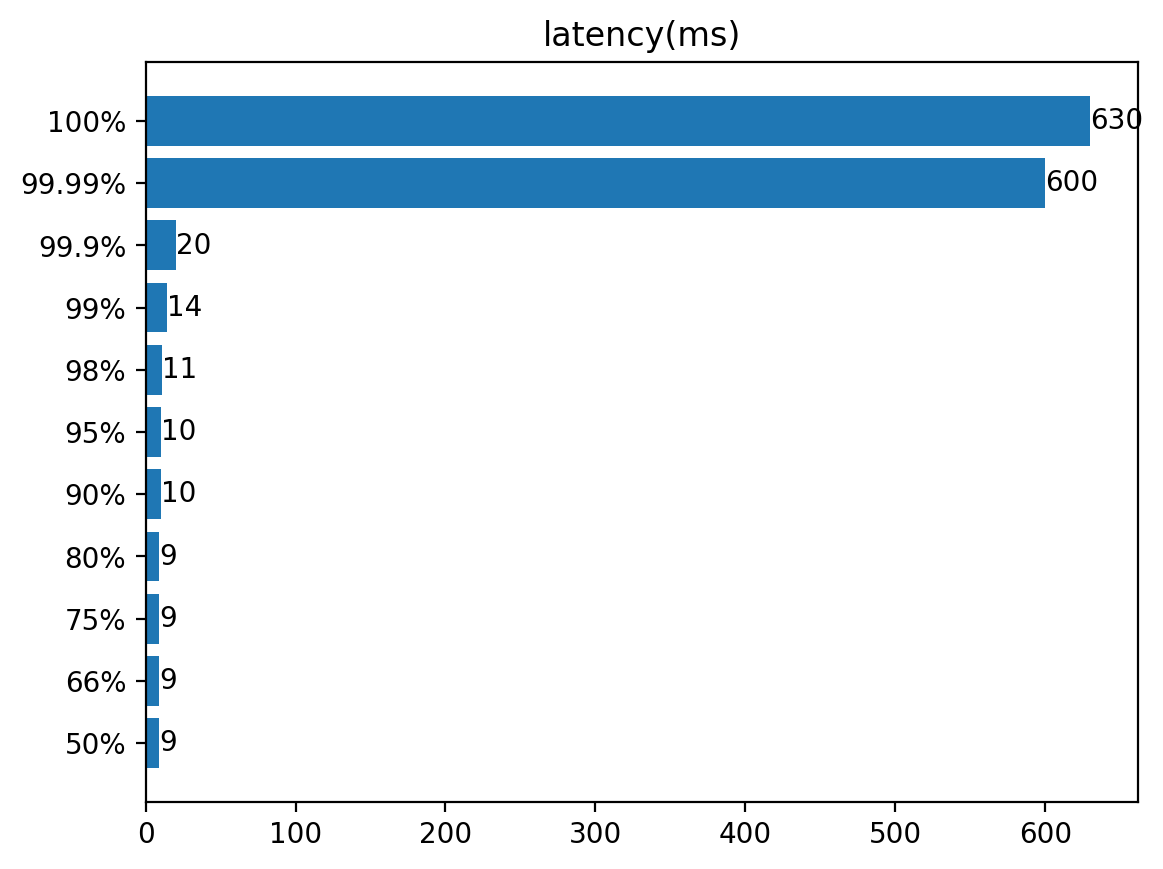

<Figure size 640x480 with 0 Axes>

In [30]:
fig, ax = plt.subplots(dpi=200)
percentages = ['50%', '66%', '75%', '80%', '90%', '95%', '98%', '99%', '99.9%', '99.99%', '100%']
ax1 = plt.barh(percentages, df_stats.loc[0, percentages])

ax.bar_label(ax1)
ax.set_title("latency(ms)")
plt.show()